In this notebook we showcase how to extract most of the results presented in Figure 1 and Figure 3 of our paper. Namely, we use different approaches to characterize the LLPS mechanism present in our experiment by means of various analysis approaches.

# The dataset
We start by showing some properties of the experimental datasets we will characterize. We have access to 6 sets of trajectories, one for each hormone concentration. Let's load them, as well as some needed packages and functions. In particular, we use the [`andi_datasets` library](https://github.com/AnDiChallenge/andi_datasets) for the analysis of the diffusion and turning angles.

In [1]:
import numpy as np
from utils import diff_coeff, file_to_np

# Load some of the analysis features of the andi_datasets library:
from andi_datasets.analysis import dataset_angles, msd_analysis

import scipy.io
file = scipy.io.loadmat('../experimental_data/Trajectories_PR.mat')
# in the following file, each experiment is accessed with the following names:
names_exp = ['Trajectories_EtOH', 'Trajectories_1pM', 'Trajectories_10pM', 'Trajectories_100pM', 'Trajectories_1nM', 'Trajectories_10nM']

We first check how long are actually the trajectories (Supp. Fig. S3 A):

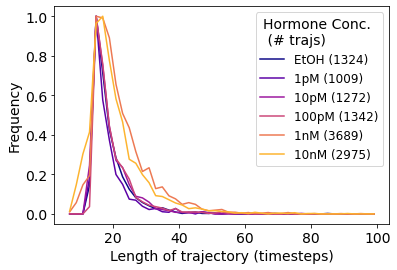

In [2]:
# soome plot properties
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plasma = plt.cm.get_cmap('plasma',7); colors = plasma(range(6))

bins = np.arange(5,100,2)
for idx, name in enumerate(names_exp):
    # Get the index of the trajectories
    index = file[name][:,-1]
    # Count how many times the index appears to get the length of the traj
    _, counts = np.unique(index, return_counts = True)
  
    h, e = np.histogram(counts, bins = bins)
    plt.plot(e[1:], h/np.max(h), c = colors[idx], label = name[13:]+f' ({len(counts)})')

plt.xlabel('Length of trajectory (timesteps)')
plt.ylabel('Frequency')
plt.legend(title = 'Hormone Conc. \n (# trajs)', fontsize = 12)

We can do a quick exploration of their anomalous diffusion behaviour by plotting the tMSD of sme trajectories:

''

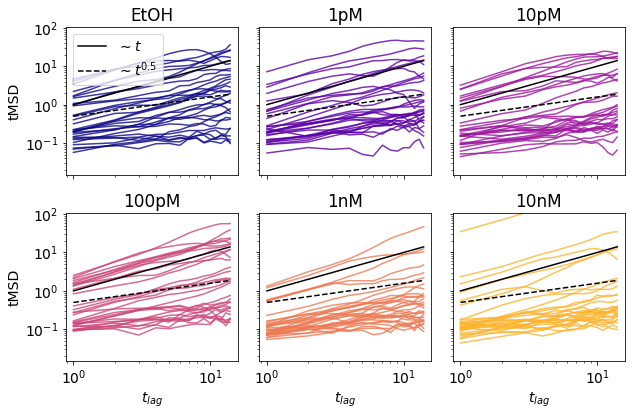

In [3]:
_, axs = plt.subplots(2, 3, figsize = (9, 6), tight_layout = True)
t_lags = np.arange(1, 15)

num_tmsd = 30
tmsds = np.zeros((len(names_exp), num_tmsd, len(t_lags)))

for idxexp, (name, ax) in enumerate(zip(names_exp, axs.flatten())):
    
    trajs = file_to_np(file[name])[::-1]
    
    count = 0; t_idx = -1
    while count < num_tmsd:
        t_idx += 1
        t = trajs[t_idx]
        if len(t) > 30:
            tmsd = msd_analysis().tamsd(t, t_lags=t_lags)

            ax.loglog(t_lags, tmsd, c = colors[idxexp], alpha = 0.8)
            count += 1
    ax.set_title(name[13:])
    
    # Scaling eye guides
    ax.plot(t_lags, t_lags, c = 'k', label = r'$\sim t$')
    ax.plot(t_lags, 0.5*t_lags**0.5, c = 'k', ls = '--', label = r'$\sim t^{0.5}$')
    
axs[0,0].legend()
plt.setp(axs[-1,:], xlabel = r'$t_{lag}$')
plt.setp(axs[:, 0], ylabel = r'tMSD')
plt.setp(axs[0,:], xticklabels = '');
plt.setp(axs[:, 1:], yticklabels = '')
plt.setp(axs, ylim = (1.5e-2, 105))
;

# Extracting diffusion coefficients and turning angles
We will first calculate the diffusion coefficient and turning angle for the trajectories at different hormone concentration, as done in Figure 1. 

''

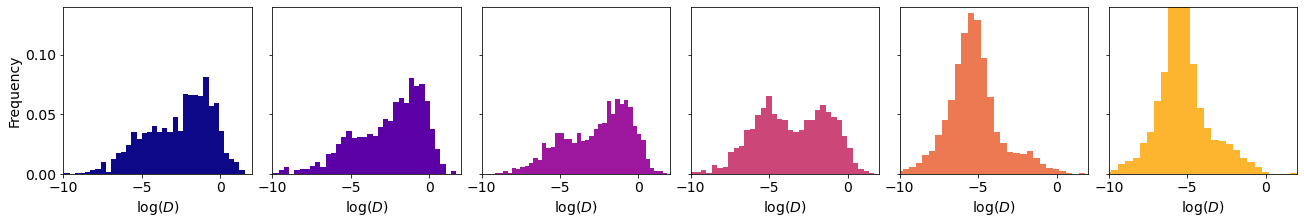

In [ ]:
# Figures initialization
fig, axs_d = plt.subplots(1, 6, constrained_layout=True, figsize = (6*3,1*3))
fig, axs_a = plt.subplots(1, 6, constrained_layout=True, figsize = (6*3,1*3), subplot_kw={'projection': 'polar'})

# We store the anisotropy for next plots
anisotropy = []

# Now we loop over the hormone concentrations
for idx, (name, axd, axa, c) in enumerate(zip(names_exp, axs_d.transpose(), axs_a.transpose(), colors)):    
    
    #### Calcultate the diffusion coefficient
    trajs = file_to_np(file[name])
    D = diff_coeff(trajs)
    D = D[D != 0]    
    
    w_a = np.ones_like(D)/float(len(D))    
    axd.hist(np.log(D), bins = 40, facecolor = c,  alpha = 1, weights = w_a)
    
    ### Calculate the turning angles
    trajs_2d = file_to_np(file[name], dim = 2)
    angles = np.array(dataset_angles(trajs_2d))    
    # We also calculate the anisotropy, which we will latter plot
    anisotropy.append(len(angles[(angles > 270) | (angles < 30)])/len(angles[(angles > 150) & (angles < 210)]))
    
    w_b = np.ones_like(angles)/float(len(angles))
    axa.hist(np.pi+angles*2*np.pi/360, bins = 50, facecolor = c,  alpha =  1, weights = w_b)
    axa.set_yticklabels([])
    axa.set_ylim(ymax = 0.04)
    
# Some plotting details   
axs_d[0].set_ylabel('Frequency')
plt.setp(axs_d, xlim = [-10,2], xlabel = r'$\log (D)$', ylim = [0, 0.14])
plt.setp(axs_d[1:], yticklabels = [])
;

From the calculations made in the previous cell, we can plot the anisotropy as a function of the hormone concentration:

In [ ]:
fig, ax = plt.subplots(figsize = (5,3))
conc = np.arange(-13, -7, 1)

ax.plot(conc, anisotropy,'k', alpha = 0.5, zorder = -1)
ax.scatter(conc, anisotropy, c = colors, s = 100, zorder =1)

plt.setp(ax, xticks=conc, xticklabels=[n[13:] for n in names_exp])
for C in conc:
    ax.axvline(C, ls = '--', c = 'k', alpha = 0.3, zorder = -1)
ax.set_xlabel('R5020 Concentration (M)')
ax.set_ylabel('Anisotropy')